# Wake Deficit Models

The wake deficit models compute the wake deficit caused by a single wind turbine. In PyWake, there are several wake deficit models, which include:

- [NOJDeficit](#NOJDeficit)
- [TurboNOJDeficit](#TurboNOJDeficit)
- [FugaDeficit](#FugaDeficit)
- [BastankhahGaussianDeficit](#BastankhahGaussianDeficit)
- [IEA37SimpleBastankhahGaussianDeficit](#IEA37SimpleBastankhahGaussianDeficit)
- [NiayifarGaussianDeficit](#NiayifarGaussianDeficit)
- [ZongGaussianDeficit](#ZongGaussianDeficit)
- [CarbajofuertesGaussianDeficit](#CarbajofuertesGaussianDeficit)
- [TurboGaussianDeficit](#TurboGaussianDeficit)
- [GCLDeficit](#GCLDeficit)
- [SuperGaussianDeficit](#SuperGaussianDeficit)

**Note**: The implementation of the deficit models is highly vectorized and therefore suffixes are used to indicate the dimension of variables. The suffixes used in this context are:

- i: source wind turbines
- j: destination wind turbines
- k: wind speeds
- l: wind directions

**This means that** `deficit_ijlk[0,1,2,3]` **holds the deficit caused by the first turbine on the second turbine for the third  wind direction and fourth wind speed**.

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [2]:
#here we import all wake deficit models available in PyWake
import numpy as np
import matplotlib.pyplot as plt
import os
import py_wake

from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site

site = Hornsrev1Site()
windTurbines = V80()

from py_wake import NOJ
from py_wake import Fuga
from py_wake import FugaBlockage
from py_wake import BastankhahGaussian

# Path to Fuga look-up tables
lut_path = os.path.dirname(py_wake.__file__)+'/tests/test_files/fuga/2MW/Z0=0.03000000Zi=00401Zeta0=0.00E+00.nc'

models = {'NOJ': NOJ(site,windTurbines), 
          'Fuga': Fuga(lut_path,site,windTurbines),
          'FugaBlockage': FugaBlockage(lut_path,site,windTurbines), 
          'BGaus': BastankhahGaussian(site,windTurbines)
         }

In addition, these models can easily be combined with other models to better describe the wake behind the turbine, e.g. NOJ with linear sum superposition:

In [3]:
from py_wake.superposition_models import LinearSum

models['NOJLinear'] = NOJ(site,windTurbines,superpositionModel=LinearSum())

Or models can be combined in custom ways, e.g. `NOJDeficit` for the wake, `LinearSum` superposition and `SelfSimilarityDeficit` for the blockage:

In [4]:
from py_wake.wind_farm_models import All2AllIterative
from py_wake.deficit_models import NOJDeficit, SelfSimilarityDeficit

models['NOJ_ss'] = All2AllIterative(site,windTurbines,
                                          wake_deficitModel=NOJDeficit(),
                                          superpositionModel=LinearSum(), 
                                          blockage_deficitModel=SelfSimilarityDeficit())

##  Definition and configuration

First, we create some functions to visualize wake maps for different conditions and wake models.

In [5]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from py_wake.deficit_models.deficit_model import WakeDeficitModel, BlockageDeficitModel
from py_wake.deficit_models.no_wake import NoWakeDeficit
from py_wake.site._site import UniformSite
from py_wake.flow_map import XYGrid
from py_wake.turbulence_models import CrespoHernandez
from py_wake.utils.plotting import setup_plot

#turbine diameter
D = 80

def get_flow_map(model=None, grid=XYGrid(x=np.linspace(-200, 500, 200), y=np.linspace(-200, 200, 200), h=70),
                 turbulenceModel=CrespoHernandez()):
    blockage_deficitModel = [None, model][isinstance(model, BlockageDeficitModel)]
    wake_deficitModel = [NoWakeDeficit(), model][isinstance(model, WakeDeficitModel)]
    wfm = All2AllIterative(UniformSite(), V80(), wake_deficitModel=wake_deficitModel, blockage_deficitModel=blockage_deficitModel,
                           turbulenceModel=turbulenceModel)
    return wfm(x=[0], y=[0], wd=270, ws=10, yaw=0).flow_map(grid)

def plot_deficit_map(model, cmap='Blues', levels=np.linspace(0, 10, 55)):
    fm = get_flow_map(model)
    fm.plot(fm.ws - fm.WS_eff, clabel='Deficit [m/s]', levels=levels, cmap=cmap, normalize_with=D)
    setup_plot(grid=False, ylabel="Crosswind distance [y/D]", xlabel= "Downwind distance [x/D]",
               xlim=[fm.x.min()/D, fm.x.max()/D], ylim=[fm.y.min()/D, fm.y.max()/D], axis='auto')

def plot_wake_deficit_map(model):
    cmap = np.r_[[[1,1,1,1],[1,1,1,1]],cm.Blues(np.linspace(-0,1,128))] # ensure zero deficit is white
    plot_deficit_map(model,cmap=ListedColormap(cmap))

**Below are the two models in PyWake that follow a top-hat shape, and are only valid in the far wake.**

## NOJDeficit

The NOJDeficit model is implemented according to Niels Otto Jensen, "A note on wind generator interaction." (1983), i.e. a top-hat wake.

According to Jensen, the velocity in the wake $V$ is defined as:

$$V = U\left(1 - 2a\left(\frac{r_o}{r_o + \alpha x}\right)^2\right)$$

where $U$ is the free stream velocity, $r_o$ the wake radius, $x$ the downstream distance and $\alpha$ the entraintment constant (with a value of 0.1).

Only valid in the far wake.

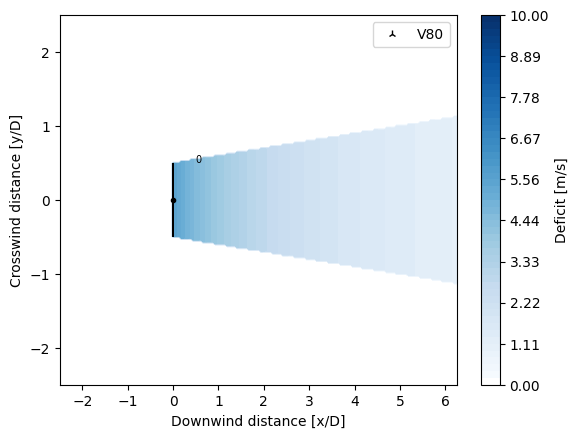

In [6]:
from py_wake.deficit_models import NOJDeficit
plot_wake_deficit_map(NOJDeficit())

## TurboNOJDeficit

Implemented according to Nygaard 2020 J. Phys.: Conf. Ser. 1618 062072 https://doi.org/10.1088/1742-6596/1618/6/062072 [1].

Modified definition of the wake expansion given by Nygaard [1], which assumes the wake expansion rate to be proportional to the local turbulence intensity in the wake. Here the local turbulence intensity is defined as the combination of ambient and wake added turbulence. Using the added wake turbulence model by Frandsen and integrating, an analytical expression for the wake radius can be obtained.

The definition in [1] of ambient turbulence is the free-stream TI and for this the model constant A has been tuned, however a fully consistent formulation of the model should probably use the locally effective TI, which includes the added turbulence from upstream turbines. 

The velocity deficit is calculated as in the `NOJDeficit` model, with a modification of the wake radius term $r_o$, given by:

$$
\begin{aligned}
D_w(x)=0.5 + & \frac{A I_0 D}{\beta} \\ & \times \left(\sqrt{(\alpha+\beta x / D)^2+1}-\sqrt{1+\alpha^2}-\ln \left[\frac{\left(\sqrt{(\alpha+\beta x / D)^2+1}+1\right) \alpha}{\left(\sqrt{1+\alpha^2}+1\right)(\alpha+\beta x / D)}\right]\right)
\end{aligned}
$$

where $A$ is the wake expansion parameter, set to a constant value of 0.6, $I_0$ is the free stream TI, $D$ is the rotor diameter, $x$ the downstream distance and $\alpha$ and $\beta$ are parameters that depend on the turbulence $I_0$ and the turbine's $C_T$.

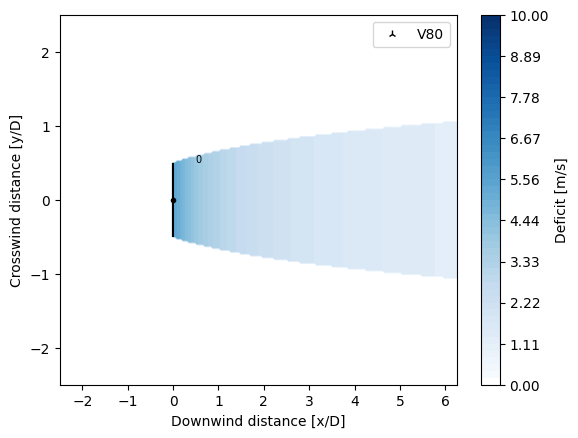

In [7]:
from py_wake.deficit_models import TurboNOJDeficit
plot_wake_deficit_map(TurboNOJDeficit())

**The rest of the models follow a Gaussian shape, with the advantage of having models for calculation of the near wake (Fuga, Zong Gaussian, Super Gaussian) as well as a model to simulate blockage (Fuga)**

## BastankhahGaussianDeficit

The Bastankhah Gaussian Deficit model is implemented according to Bastankhah M and Porté-Agel F. "A new analytical model for wind-turbine wakes" J. Renew. Energy. 2014;70:116-23.

By applying mass and momentum conservation and assuming a self-similar Gaussian profile for the wake, a general expression for the velocity deficit is derived:

$$
\frac{\Delta U}{U_{\infty}}=C(x) e^{-\frac{x^2}{2 \sigma^2}}
$$

The maximum velocity deficit at the center of the wake $C(x)$ is defined by:

$$
C(x)=1-\sqrt{1-\frac{C_{\mathrm{T}}}{8\left(\sigma / d_0\right)^2}}
$$

and the wake width ($\sigma$) is defined as:

$$\frac{\sigma}{d_0} = k^* x / d_0+\varepsilon$$

where $k$ represents the wake expansion parameter and $\varepsilon$ = 0.2 $\beta$, with $\beta$ being a parameter function of the turbine's $C_T$.

Thus, the normalized velocity deficit can be calculated as:

$$
\begin{aligned}
\frac{\Delta U}{U_{\infty}}= & \left(1-\sqrt{1-\frac{C_{\mathrm{T}}}{8\left(k^* x / d_0+\varepsilon\right)^2}}\right) \\
& \times \exp \left(-\frac{1}{2\left(k^* x / d_0+\varepsilon\right)^2}\left\{\left(\frac{z-z_{\mathrm{h}}}{d_0}\right)^2+\left(\frac{y}{d_0}\right)^2\right\}\right)
\end{aligned}
$$

where $C_T$ is the turbine's thrust coefficient, $x$ the downstream distance, $z_H$ the turbine's hub height, and $y$ and $z$ the spanwise and vertical coordinates, respectively.

The model is valid in the far wake only.

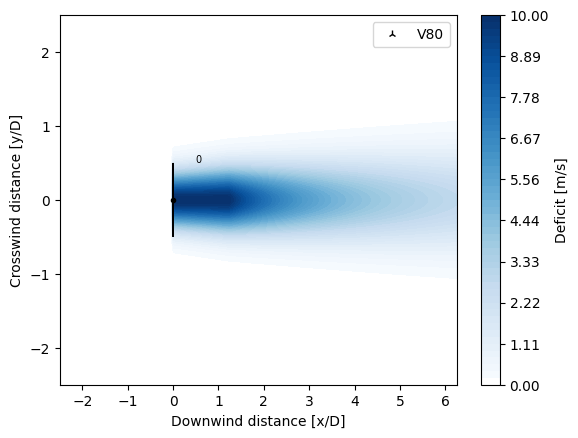

In [8]:
from py_wake.deficit_models import BastankhahGaussianDeficit
plot_wake_deficit_map(BastankhahGaussianDeficit())

## IEA37SimpleBastankhahGaussianDeficit

The IEA37 Simple Bastankhah Gaussian Deficit model is implemented according to the [IEA task 37 documentation](https://github.com/byuflowlab/iea37-wflo-casestudies/blob/master/cs1-2/iea37-wakemodel.pdf) and is equivalent to `BastankhahGaussianDeficit` for:

$$beta=1/\sqrt{8} \sim ct=0.9637188$$

The model is valid in the far wake only.

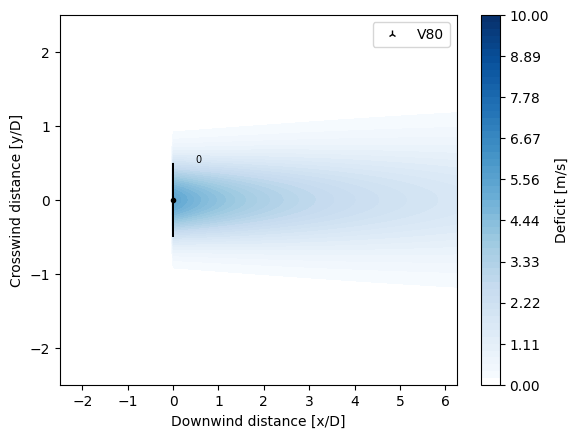

In [9]:
from py_wake.deficit_models import IEA37SimpleBastankhahGaussianDeficit
plot_wake_deficit_map(IEA37SimpleBastankhahGaussianDeficit())

## NiayifarGaussianDeficit

Implemented according to Amin Niayifar and Fernando Porté-Agel, "Analytical Modeling of Wind Farms: A New Approach for Power Prediction", Energies 2016, 9, 741; doi:10.3390/en9090741.

The calculation of the velocity deficit is made as in `BastankhahGaussianDeficit`, with the modification of the wake expansion parameter $k^*$.

This wake deficit model accounts for the local turbulence intensity when evaluating the wake expansion. The expansion rate $k^*$ varies linearly with local turbluence intensity:

$$k^* = a1 I + a2$$

The default constants are set according to publications by Porte-Agel's group, which are based on LES simulations, where $a1 = 0.3837$ and $a2 = 0.003678$. Lidar field measurements by Fuertes et al. (2018) indicate that a = [0.35, 0.0] is also a valid selection.

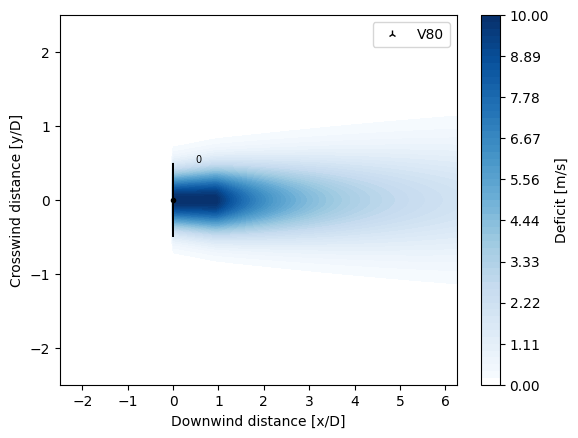

In [10]:
from py_wake.deficit_models import NiayifarGaussianDeficit
plot_wake_deficit_map(NiayifarGaussianDeficit(a=[0.38, 4e-3]))

## ZongGaussianDeficit

Implemented according to Haohua Zong and Fernando Porté-Agel, "A momentum-conserving wake superposition method for wind farm power prediction", J. Fluid Mech. (2020), vol. 889, A8; doi:10.1017/jfm.2020.77.

Based on the `NiayifarGaussianDeficit` model, the wake expansion is also function of the local turbulence intensity and the wake width expression now follows the approach by Shapiro et al. (2018). Additional to the model of Niayifar et al. is a new wake width ($\sigma$) expression, which uses the near-wake length estimation by Vermeulen (1980).

The near-wake length expression is defined as:

$$
x_n=\frac{\sqrt{0.214+0.144 m}(1-\sqrt{0.134+0.124 m})}{(1-\sqrt{0.214+0.144 m}) \sqrt{0.134+0.124 m}} \frac{r_0}{(d r / d x)}
$$

With the new expression for the wake width represented by:

$$
\sigma = \epsilon + k_w \ln \left[1+\exp \left(\frac{x-x_n}{D}\right)\right] * D
$$

where $\epsilon = (1 / \sqrt{8}) C_T$ and $k_w$ is the wake expansion rate.

The thrust coefficient used in the deficit calculation is now written as an error function of the streamwise coordinate due to the effect of the near-wake pressure gradient.

$$
C_t^i(x)= C_T (1+\operatorname{erf}(x / D)) / 2
$$

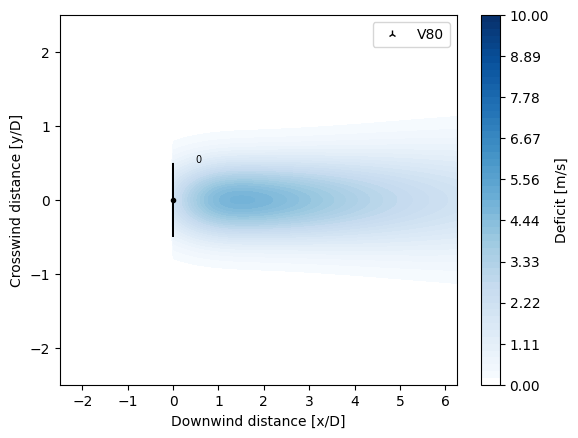

In [11]:
from py_wake.deficit_models import ZongGaussianDeficit
plot_wake_deficit_map(ZongGaussianDeficit(a=[0.38, 4e-3]))

## CarbajoFuertesGaussianDeficit

Modified version from the `ZongGaussianDeficit` model with Gaussian constants, as seen in: Fernando Carbajo Fuertes, Corey D. Markfor and Fernando Porté-Agel, "Wind TurbineWake Characterization with Nacelle-Mounted Wind Lidars for Analytical Wake Model Validation", Remote Sens. 2018, 10, 668; doi:10.3390/rs10050668.

Carbajo Fuertes et al. derived Gaussian wake model parameters from nacelle liadar measurements from a 2.5MW turbine and found a
variation of epsilon with wake expansion, this in fact identical to the formulation by Zong, only that the near-wake length is fixed for Carbajo Fuertes at $xth = 1.91 (x/D)$. We took the relationships found by them and incorporated them into the Zong formulation. This wake deficit model includes an empirical correlation for epsilon as well as new constants for the wake expansion factor equation.

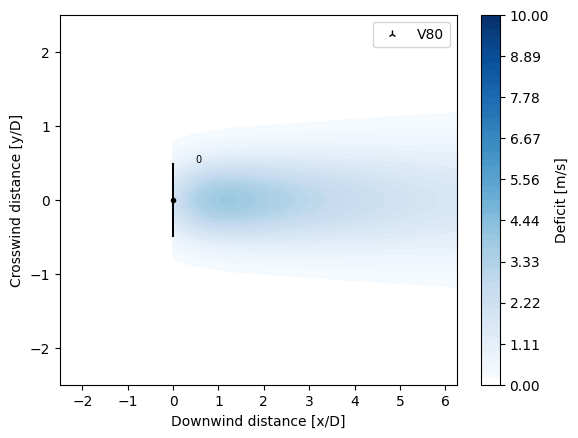

In [12]:
from py_wake.deficit_models import CarbajofuertesGaussianDeficit
plot_wake_deficit_map(CarbajofuertesGaussianDeficit())

## TurboGaussianDeficit

Implemented similar to Ørsted's TurbOPark model (https://github.com/OrstedRD/TurbOPark).

The calculation of the deficit is similar to that in `TurboNOJDeficit` with the distinction of assuming a Gaussian shape for the expansion of the wake using the wake width ($\sigma$) expression instead of the wake radius. The $\epsilon$ parameter is defined as in `BastahnkhahGaussianDeficit`, 0.2 $\beta$.

$$
\begin{aligned}
\frac{\sigma_{w, i}\left(\hat{x}_i\right)}{D_i}= \epsilon_i + & \frac{A I_0}{\beta} \\ & \times \left(\sqrt{\left(\alpha+\beta \hat{x}_i / D_i\right)^2+1}-\sqrt{1+\alpha^2}-\ln \left[\frac{\left(\sqrt{\left(\alpha+\beta \hat{x}_i / D_i\right)^2+1}+1\right) \alpha}{\left(\sqrt{1+\alpha^2}+1\right)\left(\alpha+\beta \hat{x}_i / D_i\right)}\right]\right)
\end{aligned}
$$

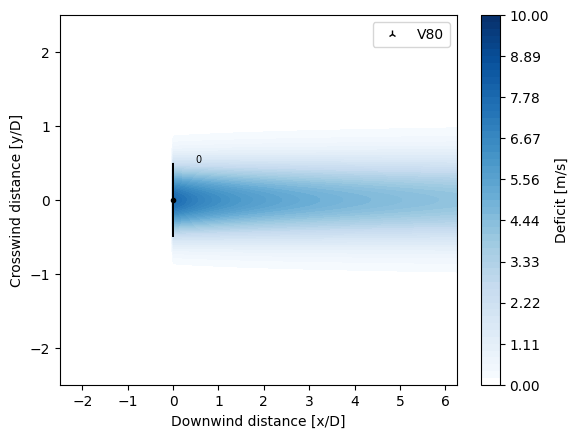

In [13]:
from py_wake.deficit_models import TurboGaussianDeficit
plot_wake_deficit_map(TurboGaussianDeficit())

## SuperGaussianDeficit

Implemented according to Blondel and Cathelain (2020), "An alternative form of the super-Gaussian wind turbine wake model" Wind Energ. Sci., 5, 1225–1236, 2020 https://doi.org/10.5194/wes-5-1225-2020 [1].

New calibrated parameters taken from Blondel (2023), "Brief communication: A momentum-conserving superposition method applied to the super-Gaussian wind turbine wake model", Wind Energ. Sci., 8, 141–147, 2023, 2023 https://doi.org/10.5194/wes-8-141-2023 [2].

The Super Gaussian deficit model is derived from the general equation for velocity deficit seen in `BastankhahGaussianDeficit` with the addition of the super gaussian order $n$, which describes the evolution of the wake. In this case, the wake profile transitions from top-hat to gaussian, with high values of $n$ representing the near wake and low values (approaching $n =2$) representing a purely Gaussian profile.

The velocity deficit is calculated as follows:

$$
\frac{U_{\infty}-U_{\mathrm{w}}}{U_{\infty}}=C(x) e^{-\bar{r}^n /\left(2 \sigma^2\right)}
$$

where the maximum velocity deficit $C(x)$ is defined as:

$$
C(x)=2^{2 / n-1}-\sqrt{2^{4 / n-2}-\frac{n C_T}{16 \Gamma(2 / n) \sigma^{4 / n}}} .
$$

The characteristic wake width ($\sigma$) is also a function of the TI as in the Bastankhah Gaussian model.

$$ \sigma = (a_s T_i + b_s)x + c_s \sqrt{\beta} $$

Lastly, the analytical super gaussian parameter $n$ is based on curve fitting and represented by:

$$ n = a_f e^{b_f x} + c_f $$

The parameters used for the model ($a_s, b_s, c_s, a_f, b_f, c_f$) are calibrated with two measurement campaings: particle velocimetry measurements and lidar measurements. Some of the parameters are dependent on the turbulence intensity and thrust coefficient, as seen in [1].

There are two classes defined:

- `BlondelSuperGaussianDeficit2020`: which uses the calibrated parameters in Table 2 and 3 in [1].
- `BlondelSuperGaussianDeficit2023`: which uses the latest calibrated parameters found in Table 1 in [2].

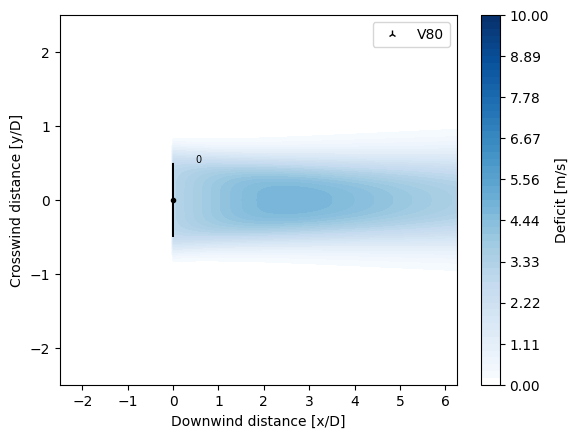

In [14]:
from py_wake.deficit_models.gaussian import BlondelSuperGaussianDeficit2020
plot_wake_deficit_map(BlondelSuperGaussianDeficit2020())

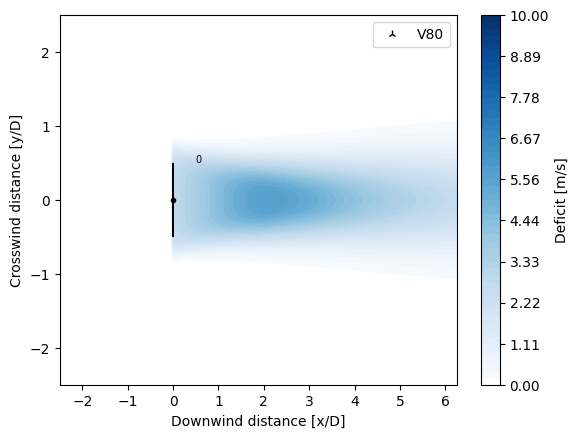

In [15]:
from py_wake.deficit_models.gaussian import BlondelSuperGaussianDeficit2023
plot_wake_deficit_map(BlondelSuperGaussianDeficit2023())

## FugaDeficit

The FugaDeficit model calculates the wake deficit based on a set of look-up tables computed by a linearized RANS solver. The look-up tables are created in advance using the [Fuga GUI](https://orbit.dtu.dk/en/publications/developments-of-the-offshore-wind-turbine-wake-model-fuga).

The most important parameters to create the look-up tables are:

- Wind turbine diameter
- Wind tubine hub height
- Terrain roughness length
- Lower and upper height of output domain (if, for example, the wake is to be studied around the rotor only or for a whole wind farm)

The FugaDeficit model can model the near wake, far wake and blockage deficit.

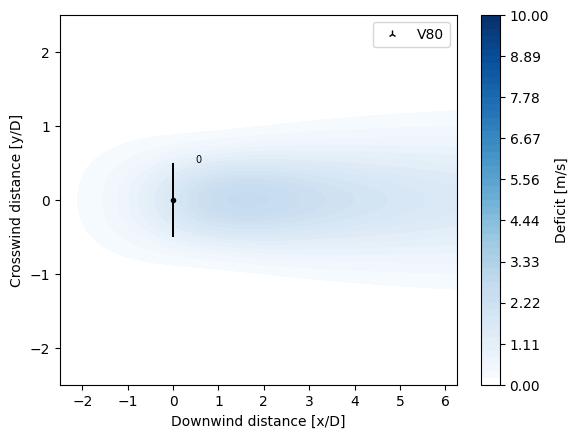

In [16]:
import py_wake
from py_wake.deficit_models import FugaDeficit

# Path to Fuga look-up tables
lut_path = os.path.dirname(py_wake.__file__)+'/tests/test_files/fuga/2MW/Z0=0.03000000Zi=00401Zeta0=0.00E+00.nc'

plot_wake_deficit_map(FugaDeficit(lut_path))

## GCLDeficit

Implemented according to Larsen, G. C. (2009), "A simple stationary semi-analytical wake model", Risø National Laboratory for Sustainable Energy,  Technical University of Denmark. Denmark. Forskningscenter Risoe. Risoe-R, No. 1713(EN).

It is based on an analytical solution of the thin shear layer approximation of the NS equations. The wake flow fields are assumed rotationally symmetric, and the rotor inflow fields are consistently assumed uniform. The effect of expansion is approximately accounted for by imposing suitable empirical downstream boundary conditions on the wake expansion that depend on the rotor thrust and the ambient turbulence conditions, respectively.

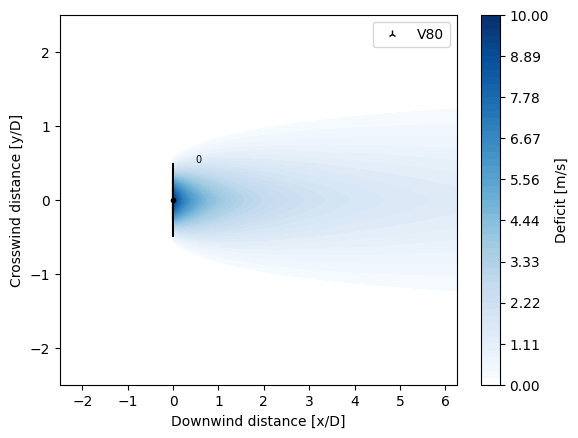

In [17]:
from py_wake.deficit_models import GCLDeficit
plot_wake_deficit_map(GCLDeficit())

## Comparing wake deficit models

In [20]:
#printing all available wake deficit models in PyWake
from py_wake.utils.model_utils import get_models
from py_wake.deficit_models.deficit_model import WakeDeficitModel

deficitModels = get_models(WakeDeficitModel)
for deficitModel in deficitModels:
    print (deficitModel.__name__)

NOJDeficit
FugaDeficit
FugaMultiLUTDeficit
FugaYawDeficit
BastankhahGaussianDeficit
BlondelSuperGaussianDeficit2020
BlondelSuperGaussianDeficit2023
CarbajofuertesGaussianDeficit
IEA37SimpleBastankhahGaussianDeficit
NiayifarGaussianDeficit
TurboGaussianDeficit
ZongGaussianDeficit
GCLDeficit
NoWakeDeficit
NOJLocalDeficit
TurboNOJDeficit


**1) Deficit along center line**

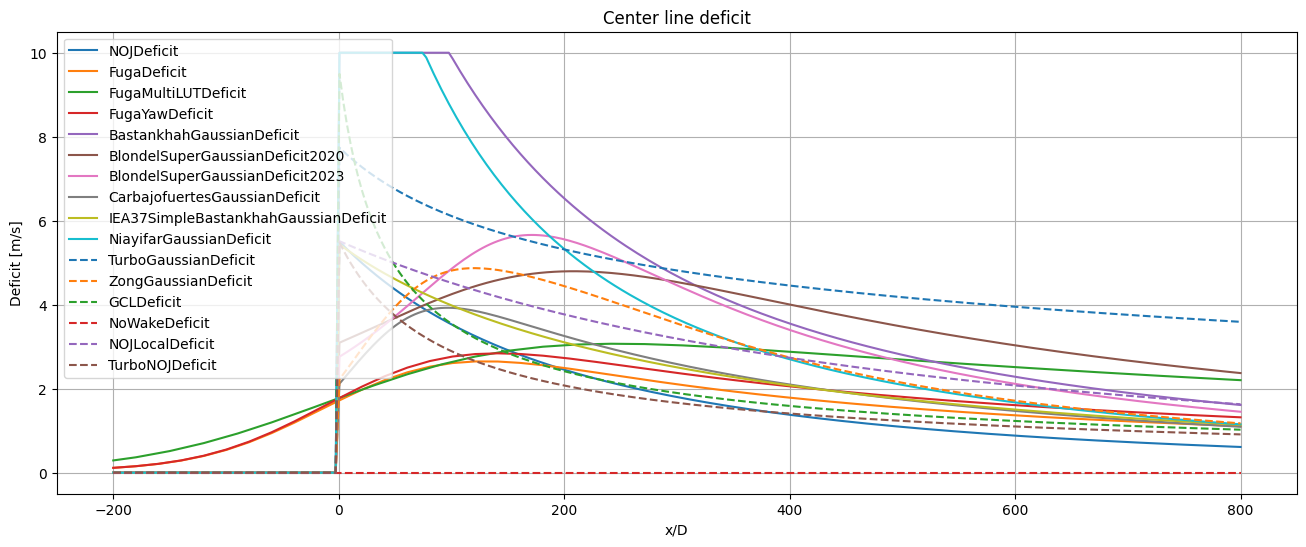

In [21]:
plt.figure(figsize=((16,6)))
for i, deficitModel in enumerate(deficitModels):
    fm = get_flow_map(deficitModel(), XYGrid(x=np.linspace(-200,800,300), y=0))
    plt.plot(fm.x, 10-fm.WS_eff.squeeze(), ('-','--')[i//10], label=deficitModel.__name__)
setup_plot(title="Center line deficit", xlabel='x/D', ylabel='Deficit [m/s]')

**2) Deficit profile downstream**

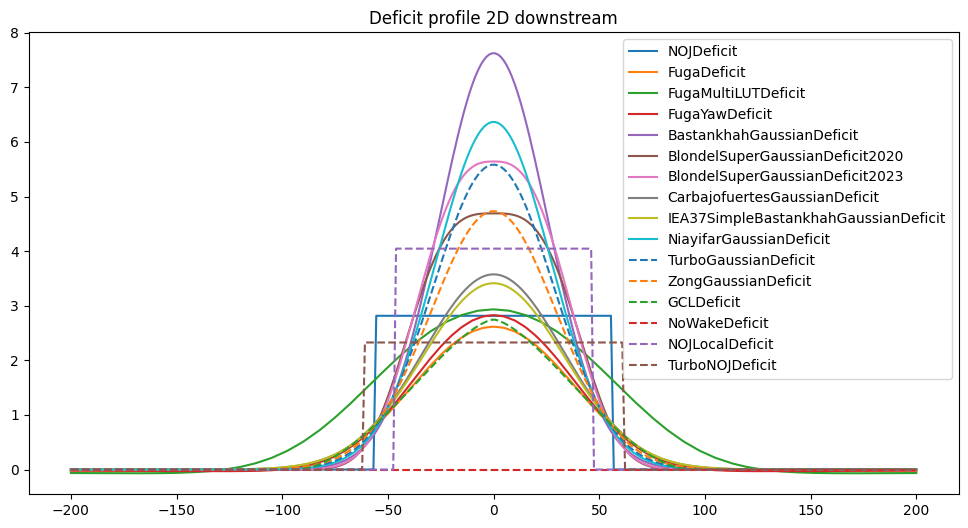

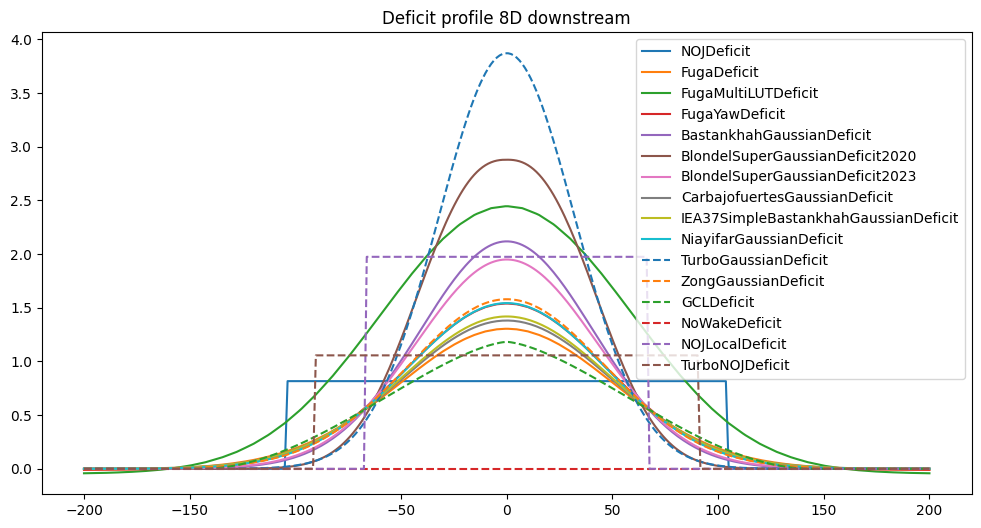

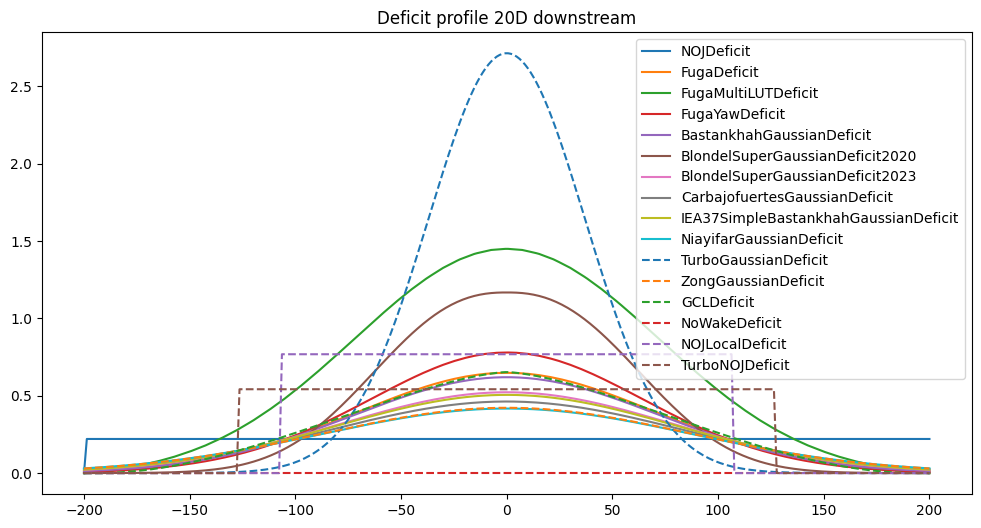

In [22]:
for d in 2,8,20:
    plt.figure(figsize=((12,6)))
    for i, deficitModel in enumerate(deficitModels):
        fm = get_flow_map(deficitModel(), XYGrid(x=d*D, y=np.linspace(-200,200,300)))
        plt.plot(fm.y, 10-fm.WS_eff.squeeze(), ('-','--')[i//10], label=deficitModel.__name__)
    plt.title(f'Deficit profile {d}D downstream')
    plt.legend()

## Implement your own deficit models

Deficit models must subclass `DeficitModel`and thus must implement the `calc_deficit` method and a class variable, `args4deficit` specifying the arguments required by its `calc_deficit` method

```python 
class DeficitModel(ABC):
    args4deficit = ['WS_ilk', 'dw_ijlk']

    @abstractmethod
    def calc_deficit(self):
        """Calculate wake deficit caused by the x'th most upstream wind turbines
        for all wind directions(l) and wind speeds(k) on a set of points(j)

        This method must be overridden by subclass

        Arguments required by this method must be added to the class list
        args4deficit

        See class documentation for examples and available arguments

        Returns
        -------
        deficit_ijlk : array_like
        """
```

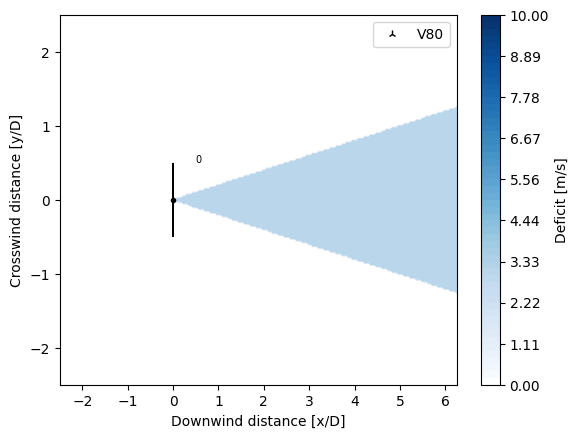

In [23]:
from py_wake.deficit_models.deficit_model import WakeDeficitModel
from numpy import newaxis as na
class MyDeficitModel(WakeDeficitModel):

    def calc_deficit(self, WS_ilk, dw_ijlk, cw_ijlk,**_):
        # 30% deficit in downstream triangle
        ws_10pct_ijlk = 0.3*WS_ilk[:,na]
        triangle_ijlk = (self.wake_radius(dw_ijlk=dw_ijlk)>cw_ijlk)
        return ws_10pct_ijlk *triangle_ijlk

    def wake_radius(self, dw_ijlk, **_):
        return (.2*dw_ijlk)

plot_wake_deficit_map(MyDeficitModel())